# 生成对抗网络

生成对抗网络（Generative Adversarial Networks, GAN）是一种生成模型，它由两个神经网络组成：生成器（Generator）和判别器（Discriminator）。生成网络的目标是从样本空间$\mathcal X$中生成尽可能逼真的样本$\mathbb P_g$，而判别网络的目标是尽可能准确地区分真实样本的分布$\mathbb P$和生成样本的分布$\mathbb P_g$。两个网络的训练目标相互对抗，在对抗训练中，生成器可以学习到如何从随机噪声中重建样本。

在生成器的实现中，通常采取隐变量模型的方法，即从一个简单的分布中采样隐变量$z$，然后通过生成器$g$生成样本$x$，即$x = g(z; \theta_g)$。

设$P, Q$为两个概率分布（的概率密度），它们的差异可以通过Kullback–Leibler散度来衡量：

$$
\text{KL}(P\Vert Q) = \int P(x) \log \frac{P(x)}{Q(x)} \mathrm dx
$$

KL散度不是对称的，通常使用Jensen-Shannon散度来衡量$P, Q$两个分布之间的距离：

$$
\begin{aligned}
\text{JS}(P\Vert Q) &= \text{KL}\left(P\middle\Vert \frac{P+Q}{2}\right) + \text{KL}\left(Q\middle\Vert \frac{P+Q}{2}\right) \\
&= \int P(x) \log \frac{2P(x)}{P(x) + Q(x)} \mathrm dx + \int Q(x) \log \frac{2Q(x)}{P(x) + Q(x)} \mathrm dx \\
&= \mathbb E_{x\sim P} \log \frac{2P(x)}{P(x) + Q(x)} + \mathbb E_{x\sim Q} \log \frac{2Q(x)}{P(x) + Q(x)} \\
&= \mathbb E_{x\sim P} \log \frac{2P(x)}{P(x) + Q(x)} + \mathbb E_{x\sim Q} \log \left(2 - \frac{2P(x)}{P(x) + Q(x)}\right)
\end{aligned}
$$

判别器$D$是一个二分类器$d(x; \theta_d): \mathcal X \rightarrow [0, 1]$，输出$x$来自于真实样本的概率$P(x\sim \mathbb P \mid x)$。

$$
\begin{aligned}
d(x) &= P(x\sim \mathbb P \mid x) \\
&= \frac{P(x\sim \mathbb P, x)}{P(x)} \\
&= \frac{P(x\sim \mathbb P, x)}{P(x\sim \mathbb P, x) + P(x\sim \mathbb P_g, x)} \\
&= \frac{\mathbb P(x)}{\mathbb P(x) + \mathbb P_g(x)}
\end{aligned}
$$

与$\text{JS}$散度具有相同的形式：

$$
\begin{aligned}
\text{JS}(\mathbb P\Vert \mathbb P_g) &= \mathbb E_{x\sim \mathbb P} \log 2d(x; \theta_d) + \mathbb E_{x\sim \mathbb P_g} \log 2(1 - d(x; \theta_d)) \\
&= \log 4 + \mathbb E_{x\sim \mathbb P} \log d(x; \theta_d) + \mathbb E_{x\sim \mathbb P_g} \log (1 - d(x; \theta_d))
\end{aligned}
$$

判别器的目标是尽可能区分两个分布，即最大化$\text{JS}(\mathbb P\Vert \mathbb P_g)$，即

$$
L(\theta_d, \theta_g) = -y \log d(x; \theta_d) - (1 - y) \log (1 - d(x; \theta_d))
$$

当$x$来自于真实样本时，$y=1$；当$x$来自于生成样本时，$y=0$。相对地，生成器的分布$\mathbb P_g$来自于对隐变量$z$的变换$x = g(z; \theta_g)$，其优化目标是最小化$\text{JS}(\mathbb P\Vert \mathbb P_g)$。总体的优化目标可以写作：

$$
\max_{\theta_g} \min_{\theta_d} L(\theta_d, \theta_g) \triangleq  - \log d(x; \theta_d) - \log (1 - d(g(z; \theta_g); \theta_d))
$$

在现实优化中，生成器往往不是优化$L_g(\theta_g) = \log (1 - d(g(z; \theta_g); \theta_d))$，而是优化

$$
L_g(\theta_g) = -\log d(g(z; \theta_g); \theta_d)
$$

在每一步迭代中，先通过多步迭代优化判别器，然后再优化生成器。在优化模型的一个部分时，需要固定另一个部分的参数。

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

# SVG output
%config InlineBackend.figure_format = 'svg'

# Fix for certificate error
# https://stackoverflow.com/questions/71263622
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

导入MNIST数据集，使用生成对抗网络生成手写数字图片。

In [2]:
train_dataset = torchvision.datasets.MNIST(
    train=True, root='data',
    transform=torchvision.transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

生成器的网络结构使用MLP+ConvTranspose2d，设置隐变量的维度为128。使用反卷积操作来生成图像。为了避免生成器崩溃，在实现中需要注意以下细节：

1. 模型的输出需要用sigmoid、tanh等激活函数将输出限制在合适的范围内。此处使用tanh激活函数将输出限制在$[-1, 1]$范围内。
2. 避免引入稀疏梯度，如ReLU和MaxPool。可以使用LeakyReLU等激活函数。
3. 使用Dropout等正则化方法来避免过拟合。
4. 如果针对图像生成任务，更大的卷积核可以导致图像的平滑性更好。

In [3]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=128 * 7 * 7),
            torch.nn.LeakyReLU(0.2),
            Reshape(128, 7, 7),
        )

        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=128, out_channels=1, kernel_size=(3, 3), padding=(1, 1)
            ),
            torch.nn.Tanh(),
        )
        self.layers = torch.nn.Sequential(self.fcn, self.deconv)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

判别器使用Conv2d结构，输出维度为1。在实现中需要注意以下细节：

1. pytorch提供的MNIST数据集的特征范围在$[0, 1]$区间内，需要转化到$[-1, 1]$的范围。

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = torch.nn.Sequential(
            Reshape(1, 28, 28),
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
        )
        self.classifier = torch.nn.Sequential(
            Reshape(3136),
            torch.nn.Linear(in_features=3136, out_features=1), torch.nn.Sigmoid()
        )
        self.layers = torch.nn.Sequential(self.conv, self.classifier)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()

将两者组合得到生成对抗网络的结构。从$\text{JS}$距离的定义可以导出用于优化的交叉熵损失。在具体实现中，有以下细节需要注意：

1. 训练判别器时将真实样本的标签设置为1，生成样本的标签设置为0。相反地，训练生成器时将生成样本的标签设置为1，而不是反向优化判别器的损失。
2. 随机噪声最好使用正态分布而避免使用均匀分布。
3. 一个mini-batch中必须只有真实样本或生成样本，不能混合使用。

In [5]:
from typing import Optional

class GAN(torch.nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.loss = torch.nn.BCELoss()
        self.device = torch.device('cpu')

    def to(self, *args, **kwargs):
        if args:
            self.device = args[0]
        elif 'device' in kwargs:
            self.device = kwargs['device']
        super().to(*args, **kwargs)

    def forward(
        self, x: Optional[torch.Tensor] = None, y: Optional[torch.Tensor] = None
    ):
        assert x is not None or y is not None, 'Either x or y must be provided'
        if x is not None:
            x = x.to(self.device)
            x = x.view(x.size(0), -1)
            x = x * 2 - 1
        else:
            assert y is not None
            z = torch.randn(y.size(0), 128, device=self.device)
            x = self.generator(z)

        if y is not None:
            y = y.to(self.device)
        else:
            assert x is not None
            y = torch.ones(x.shape[0], device=self.device)

        prob = self.discriminator(x)

        return self.loss(prob, y)

model = GAN()

可以给生成器输入一个随机噪声，然后通过生成器生成图片。在训练过程中，生成器的输出会逐渐逼近真实图片的分布。

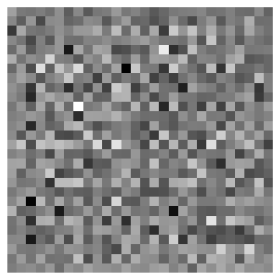

In [6]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

def plot_generator(z: torch.Tensor, model: GAN, ax: Optional[Axes] = None):
    z = z.to(model.device)
    with torch.no_grad():
        x = model.generator(z).view(28, 28).cpu().numpy() * 0.5 + 0.5

    if ax is None:
        plt.imshow(x, cmap='gray')
        plt.axis('off')
    else:
        ax.imshow(x, cmap='gray')
        ax.axis('off')

x_noise = torch.randn(1, 128)
plot_generator(x_noise, model)
plt.show()

分别为生成器和判别器设置优化器，用于更新各自对应的参数。Adam优化器对于生成对抗网络的训练效果较好。

1. 训练过程中需要注意，生成器和判别器损失函数的范围应当相近。如果一方性能过强，会导致另一方无法学习。
2. 生成器和判别器可以设置不同的学习率，或是设置不同的优化步数。不同的优化步数对模型最终的性能影响不大。

样本标签有如下设置技巧：

1. 使用平滑标签，即将真实样本的标签设置为$[0.9, 1.0]$，生成样本的标签设置为$[0.0, 0.1]$。
2. 随机反转标签，即训练判别器时按照一个较低的概率将真实样本的标签设置为0，生成样本的标签设置为1。

In [7]:
optimizer_g = torch.optim.Adam(model.generator.parameters(), lr=0.0005, weight_decay=1e-4)
optimizer_d = torch.optim.Adam(model.discriminator.parameters(), lr=0.0005, weight_decay=1e-4)
N = 100 # Number of epochs
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
discriminator_real_loss = []
discriminator_fake_loss = []
generator_loss = []

训练模型，每经过若干个epoch输出一次生成的图片

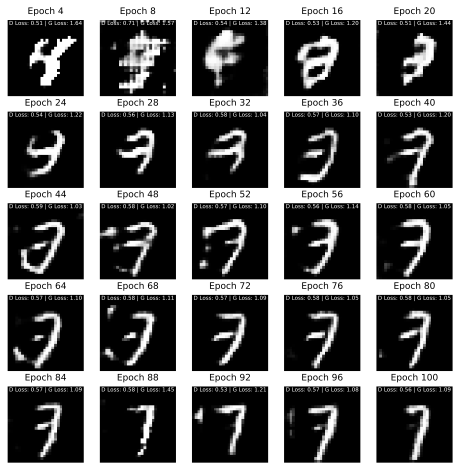

In [8]:
fig, ax = plt.subplots(5, 5, figsize=(8, 8))
axes = iter(ax.flatten())
x_noise = torch.randn(1, 128)

for epoch in range(N):
    current_real_losses = []
    current_fake_losses = []
    current_generator_losses = []

    model.train()
    model.to(device)
    for i, (x, _) in enumerate(train_loader, start=1):
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        y = torch.ones(x.size(0), device=device) * 0.95 # Label smoothing

        # Train discriminator
        loss_real = model(x, y)
        loss_real.backward()
        optimizer_d.step()
        optimizer_d.zero_grad()

        loss_fake = model(None, 1 - y)
        loss_fake.backward()
        optimizer_d.step()

        current_real_losses.append(loss_real.item())
        current_fake_losses.append(loss_fake.item())

        # Train generator
        loss_fake = model(None, y)
        loss_fake.backward()
        optimizer_g.step()

        current_generator_losses.append(loss_fake.item())

    d_loss = (sum(current_real_losses) + sum(current_fake_losses)) / \
        (len(current_real_losses) + len(current_fake_losses))
    g_loss = sum(current_generator_losses) / len(current_generator_losses)

    discriminator_real_loss.extend(current_real_losses)
    discriminator_fake_loss.extend(current_fake_losses)
    generator_loss.extend(current_generator_losses)

    model.eval()
    if (epoch + 1) % 4 == 0:
        ax = next(axes)
        plot_generator(x_noise, model, ax)
        ax.set_title(f'Epoch {epoch + 1}', fontsize=9)
        ax.text(
            0.5, 0.99, f'D Loss: {d_loss:.2f} | G Loss: {g_loss:.2f}',
            color='white', fontsize=5.5, va='top', ha='center',
            transform=ax.transAxes
        )

fig.show()

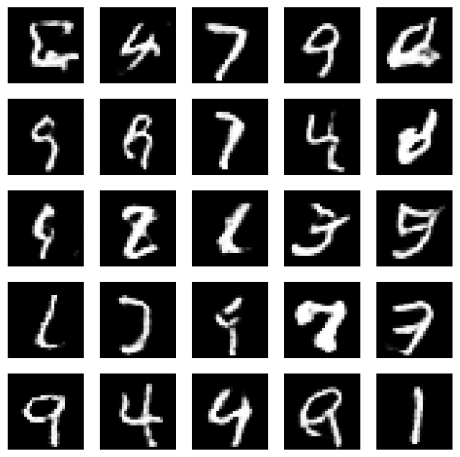

In [9]:
model.eval()
z = torch.randn(25, 128)

fig, ax = plt.subplots(5, 5, figsize=(8, 8))
for i in range(25):
    plot_generator(z[i].reshape(1, -1), model, ax[*divmod(i, 5)])

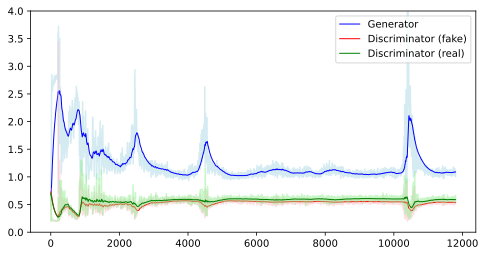

In [10]:
def ema(x, beta):
    y = x[0]
    for _ in x:
        y = beta * y + (1 - beta) * _
        yield y

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(generator_loss, color='lightblue', alpha=0.5)
ax.plot([*ema(generator_loss, 0.99)], label='Generator', color='blue', linewidth=1)
ax.plot(discriminator_fake_loss, color='pink', alpha=0.5)
ax.plot([*ema(discriminator_fake_loss, 0.99)], label='Discriminator (fake)', color='red', linewidth=1)
ax.plot(discriminator_real_loss, color='lightgreen', alpha=0.5)
ax.plot([*ema(discriminator_real_loss, 0.99)], label='Discriminator (real)', color='green', linewidth=1)
ax.set_ylim(0, 4)
ax.legend(loc='upper right')

fig.show()

Paper reference:

```bibtex

@inproceedings{goodfellow2014generative,
	author = {Goodfellow, Ian and Pouget-Abadie, Jean and Mirza, Mehdi and Xu, Bing and Warde-Farley, David and Ozair, Sherjil and Courville, Aaron and Bengio, Yoshua},
	booktitle = {Advances in Neural Information Processing Systems},
	editor = {Z. Ghahramani and M. Welling and C. Cortes and N. Lawrence and K.Q. Weinberger},
	publisher = {Curran Associates, Inc.},
	title = {Generative Adversarial Nets},
	url = {https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf},
	volume = {27},
	year = {2014}
}
```